 master-thesisInput:
- True Observations
- Number Training Steps

Output:
- New Model Parameter

Parts of Optimization:
- Initialization of Model Parameter
- tbd

# Initialization

## Import Libraries and Mount Drive

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch
from torch import distributions, optim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GitHub/master-thesis

import sys
sys.path.append('/content/gdrive/My Drive/GitHub/master-thesis')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GitHub/master-thesis


In [3]:
#%cd ..

In [4]:
from model.methods import *
from model.modelcore import epid_model
from model.modelhelper import *

## Optimization Settings

In [5]:
observation = 'hospitalization' #'newly_infected' #'hospitalization'
rolling_avg_obs = 2
# Overall Time Period
start_time='2020-08-01' # Mitte November/ Anfang Dezember bis Februar
end_time='2021-02-01' # Begin Vaccination Wave


dtype = torch.float32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #cuda:0

## Initialize Observations

In [6]:
df_obs_initial = pd.read_csv('data/observations.csv' , sep=';', thousands='.', decimal=',', encoding='utf-8', parse_dates=['Date'])

# Initialize Observations Training
df_obs, initial_newly_infected = initialize_observations(df_obs_initial, start=start_time, end=end_time, rolling_avg=rolling_avg_obs)
observed_train = torch.tensor(df_obs[observation], requires_grad=False, device=device, dtype=dtype)

df_obs.head(3)

,Date,number_of_deaths,newly_infected,hospitalization
0,2020-08-01,0.5,61.0,3.5
1,2020-08-02,0.0,71.0,3.0
2,2020-08-03,0.0,97.5,4.5


In [7]:
#for column in df_obs.columns:
#  plt.plot(df_obs['Date'], df_obs[column])
#  plt.title(column)
#  plt.show()

## Initialize Model Parameter

### Initialize helper parameter

In [8]:
cero = torch.tensor(0., requires_grad=False, device=device, dtype=dtype)

### Initialize method parameter

In [9]:
method = NN(device=device, dtype=dtype, input_size=3)

### Initialize alpha and phi

In [10]:
dict_param = initialize_parameter(['alpha', 'phi'], device, dtype)
dict_param

{'prime_values': {'alpha': tensor(0.0102, requires_grad=True),
  'phi': tensor(-0.0020, requires_grad=True)},
 'real_values': {'alpha': tensor(0.0280, grad_fn=<AddBackward0>),
  'phi': tensor(25., grad_fn=<AddBackward0>)}}

## Load Method Input Data

In [11]:
input_data = get_model_input(start=start_time, end=end_time, split_date=None, path='data/modeling/fa_data_model_input_3.csv', rolling_avg=7)
input_data.shape

(184, 3)

# Optimization

## Training

Step: 0, Learning Rate: 0.00999 Time: 0.1375, Comparison Loss: 114345.921875


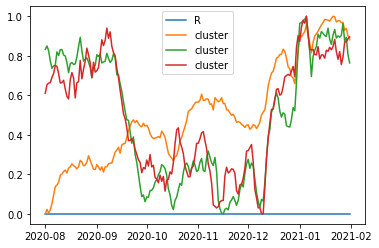

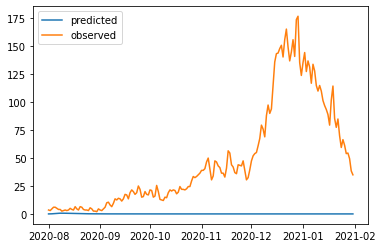

Step: 50, Learning Rate: 0.00950254422568834 Time: 0.1155, Comparison Loss: 113787.5625


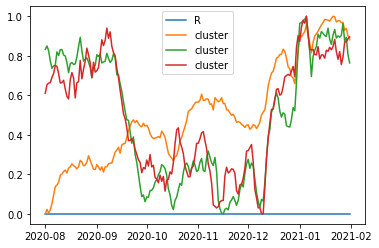

Step: 100, Learning Rate: 0.009038873549665948 Time: 0.1504, Comparison Loss: 113239.4609375


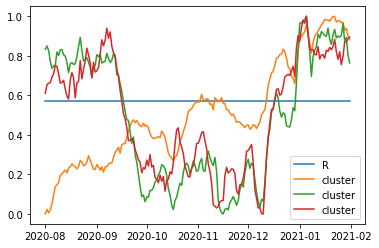

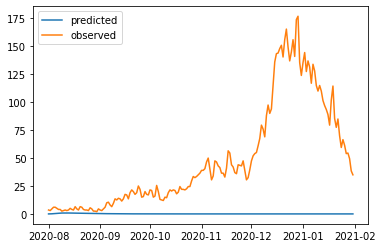

Step: 150, Learning Rate: 0.008597827393003531 Time: 0.0566, Comparison Loss: 39255.109375


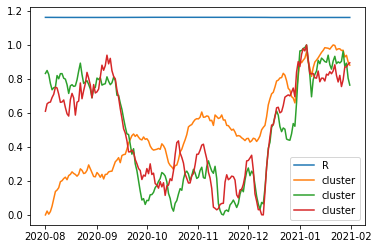

Step: 200, Learning Rate: 0.008178301806491574 Time: 0.0574, Comparison Loss: 36364.7890625


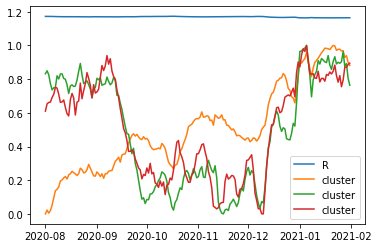

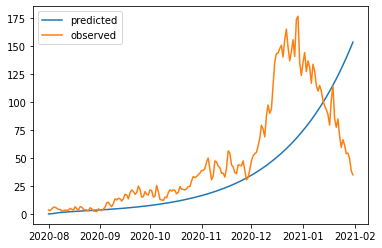

Step: 250, Learning Rate: 0.00777924670742873 Time: 0.0553, Comparison Loss: 31517.134765625


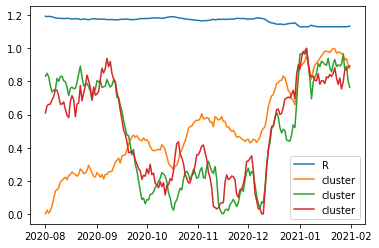

Step: 300, Learning Rate: 0.007399663251239432 Time: 0.0555, Comparison Loss: 25644.521484375


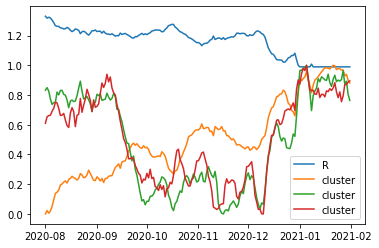

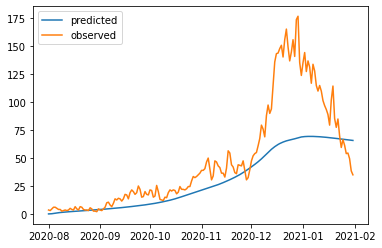

Step: 350, Learning Rate: 0.007038601331341688 Time: 0.0546, Comparison Loss: 111655.0546875


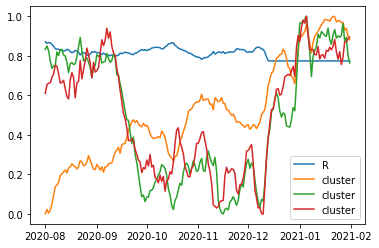

Step: 400, Learning Rate: 0.006695157201007331 Time: 0.0538, Comparison Loss: 111095.09375


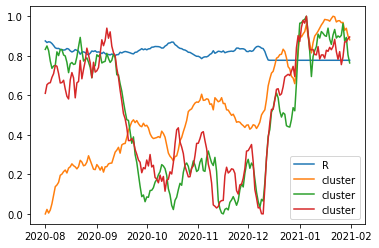

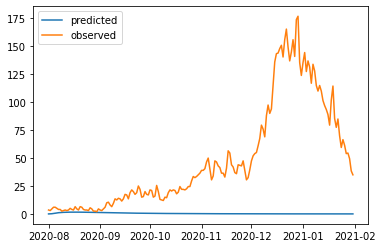

Step: 450, Learning Rate: 0.006368471211262053 Time: 0.0572, Comparison Loss: 110575.8046875


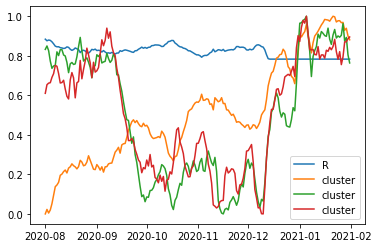

Step: 500, Learning Rate: 0.006057725659163231 Time: 0.0585, Comparison Loss: 110090.65625


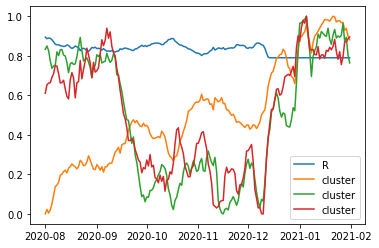

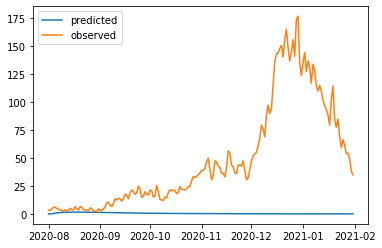

Step: 550, Learning Rate: 0.0057621427410696376 Time: 0.058, Comparison Loss: 109623.984375


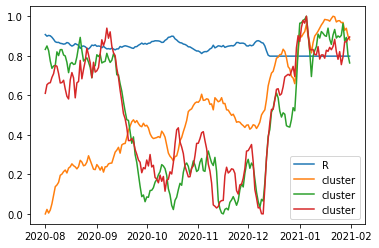

Step: 600, Learning Rate: 0.005480982605780108 Time: 0.0556, Comparison Loss: 109154.4609375


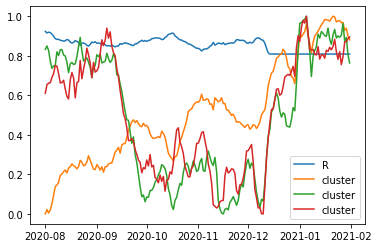

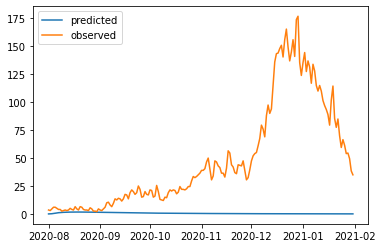

Step: 650, Learning Rate: 0.005213541502668067 Time: 0.0562, Comparison Loss: 108635.765625


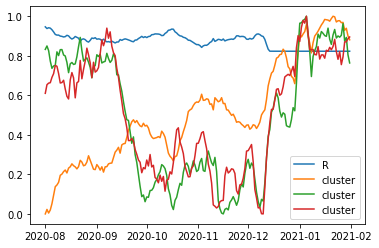

Step: 700, Learning Rate: 0.004959150020176671 Time: 0.0584, Comparison Loss: 107892.3515625


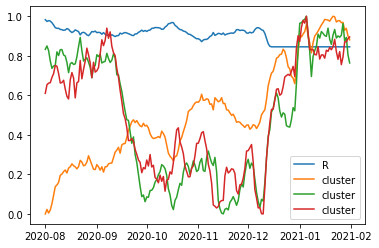

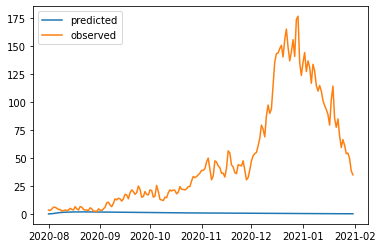

Step: 750, Learning Rate: 0.004717171410265472 Time: 0.0587, Comparison Loss: 104650.296875


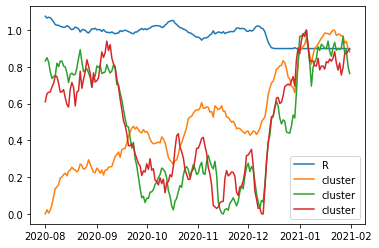

Step: 800, Learning Rate: 0.004486999994614646 Time: 0.0601, Comparison Loss: 14742.8935546875


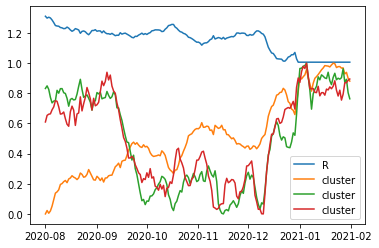

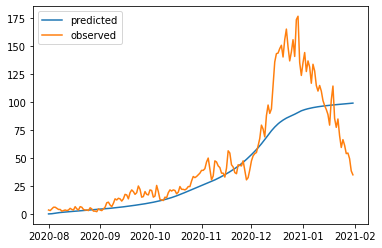

Step: 850, Learning Rate: 0.004268059648597501 Time: 0.0553, Comparison Loss: 9207.7919921875


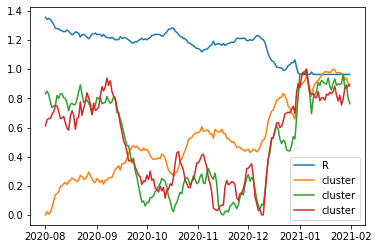

Step: 900, Learning Rate: 0.0040598023592265855 Time: 0.0565, Comparison Loss: 7047.5771484375


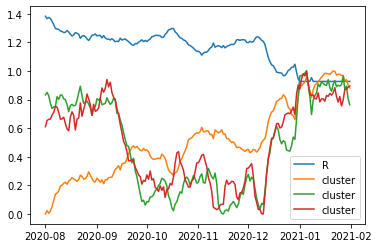

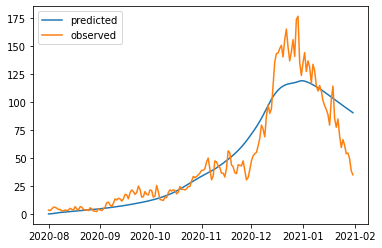

Step: 950, Learning Rate: 0.0038617068534639145 Time: 0.0552, Comparison Loss: 6034.3876953125


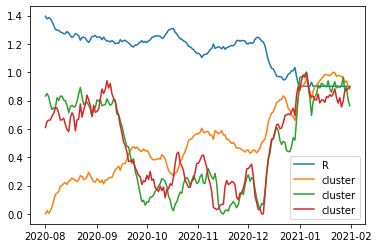

In [12]:
from torch.optim.lr_scheduler import ExponentialLR

epochs = 1000
# model_parameter = [dict_param['prime_values']['alpha'], dict_param['prime_values']['phi']] + [dict_param['prime_values']['epsilon']]

params_to_be_optimized = method.get_parameters() + [dict_param['prime_values']['phi']]
if observation == 'hospitalization':
  params_to_be_optimized = params_to_be_optimized + [dict_param['prime_values']['alpha']]

optimizer = optim.Adam(params_to_be_optimized, lr=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.999)

for i in range(epochs):
  iteration_time = time.time()
  optimizer.zero_grad()

  # transform alphi, phi
  dict_param = transform_prime_variables(dict_param)

  # forward pass
  expected = epid_model(R=method.calculate_R(input_data), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]
  
  # calc loss
  comparison_loss_train =  calc_mse(expected, observed_train) * dict_param['real_values']['phi'] #calc_negative_binomnial_loss(expected, observed_train, dict_param['real_values']['phi']) #
  method_loss = method.calculate_loss()
  model_param_loss = calc_prior_loss(dict_param, device, dtype)
  loss = comparison_loss_train + method_loss + model_param_loss

  # backward pass
  loss.backward()
  optimizer.step()
  scheduler.step()
  
  
  with torch.no_grad():
    if i % 50==0:
        current_time = round((time.time() - iteration_time),4)
        current_lr = optimizer.state_dict()['param_groups'][0]['lr']
        print(f"Step: {i}, Learning Rate: {current_lr} Time: {current_time}, Comparison Loss: {comparison_loss_train}")
        plt.plot(df_obs['Date'], method.calculate_R(input_data).cpu().detach().numpy(), label='R')
        plt.plot(df_obs['Date'], input_data, label='cluster')
        plt.legend()
        plt.show()
    if i % 100==0:
      plt.plot(df_obs['Date'], expected.cpu().detach().numpy(), label='predicted')
      plt.plot(df_obs['Date'], observed_train.cpu().detach().numpy(), label='observed')
      plt.legend()
      plt.show()

In [13]:
comparison_loss_train / dict_param['real_values']['phi']

tensor(233.5478, grad_fn=<DivBackward0>)

# Evaluation

## Train and Test Time 

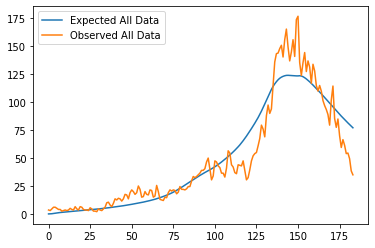

In [14]:
plt.plot(expected.cpu().detach().numpy(),label='Expected All Data')
plt.plot(observed_train.cpu().detach().numpy(),label='Observed All Data')
plt.legend()
plt.show()

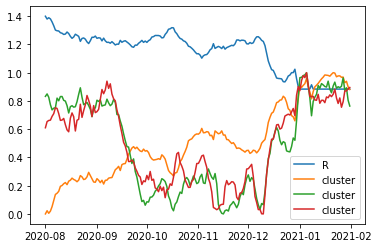

In [15]:
# Plot R-Value & Cluster Percentage
plt.plot(df_obs['Date'], method.calculate_R(input_data).cpu().detach().numpy(), label='R')
plt.plot(df_obs['Date'], input_data, label='cluster')
plt.legend()
plt.show()

## Eval What IF

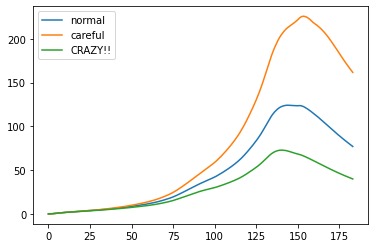

In [16]:
expected_normal = epid_model(R=method.calculate_R(input_data), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]
expected_careful= epid_model(R=method.calculate_R(input_data*0.9), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]
expected_crazy = epid_model(R=method.calculate_R(input_data*1.1), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]

plt.plot(expected_normal.cpu().detach().numpy(),label='normal')
plt.plot(expected_careful.cpu().detach().numpy(),label='careful')
plt.plot(expected_crazy.cpu().detach().numpy(),label='CRAZY!!')
plt.legend()
plt.show()

# Eval Method

In [17]:
from clustering.utils import *

In [18]:
factor_cols = get_factor_cols()
factor_cols

['F0_cautious_behaviour',
 'F1_perception_advice',
 'F2_applicability_usefullness_advice',
 'F3_behaviour_others',
 'F4_consequence_advice']

In [19]:
set(method.model.parameters())

{Parameter containing:
 tensor([ 0.0305, -0.0149,  0.5428,  0.0274,  0.0910,  0.5089],
        requires_grad=True), Parameter containing:
 tensor([ 0.4092,  0.2083, -0.0503,  0.2917], requires_grad=True), Parameter containing:
 tensor([ 1.2272e-05,  2.3434e-02, -9.8039e-02, -9.7096e-03, -3.8764e-02,
          1.1891e-03, -1.8184e-02, -6.2883e-06,  2.8001e-05,  9.5865e-02],
        requires_grad=True), Parameter containing:
 tensor([0.5332], requires_grad=True), Parameter containing:
 tensor([[ 1.9448e-01,  2.0781e-01, -4.9552e-07, -9.9104e-03, -3.6947e-02,
           1.9945e-01, -2.1413e-02,  2.2066e-01,  2.0193e-01,  2.4634e-01],
         [ 1.7237e-01,  2.0293e-01, -8.1676e-14, -9.9524e-03, -3.7120e-02,
           1.9791e-01, -2.2725e-02,  1.7941e-01,  1.8029e-01,  1.7787e-01],
         [-3.0114e-02, -4.2663e-02,  2.3349e-25, -2.2315e-24, -2.1900e-24,
          -3.9531e-02, -4.8696e-25, -3.6202e-02, -3.8664e-02, -4.6187e-02],
         [ 1.8222e-01,  2.0669e-01, -7.0295e-10, -1.0424e-0

In [20]:
model_params = torch.nn.utils.parameters_to_vector(method.model.parameters())
model_params

tensor([-6.4129e-02, -4.0797e-02, -2.6405e-02, -5.7943e-02, -4.8656e-02,
        -4.3229e-02, -4.8272e-01, -1.1172e-02, -1.3883e-01, -7.2070e-02,
        -6.3053e-02, -5.1603e-02, -2.1681e-01, -9.0033e-02, -1.0863e-01,
        -4.5229e-01, -1.0810e-02, -1.3000e-01,  3.0518e-02, -1.4885e-02,
         5.4282e-01,  2.7411e-02,  9.0955e-02,  5.0885e-01, -1.4086e-02,
        -3.4318e-02,  4.8008e-01, -1.9333e-02,  1.8055e-02,  4.4416e-01,
        -3.0455e-04, -3.0791e-02,  5.1616e-01, -6.9443e-03,  4.8594e-02,
         4.9281e-01, -2.7605e-22, -1.2191e-24, -2.0959e-04, -6.0026e-24,
         1.4149e-20, -4.1548e-04, -5.8934e-02, -3.7536e-02, -5.4294e-02,
        -5.2132e-02, -5.6205e-02, -5.4909e-02,  4.4736e-05, -6.1637e-24,
        -2.6574e-04,  1.0313e-21,  1.7082e-03,  5.2018e-04,  1.1823e-03,
        -3.1238e-02,  5.1254e-01, -3.8795e-03,  4.6955e-02,  4.7288e-01,
        -3.1382e-02,  6.0055e-25, -2.8757e-02, -3.1415e-02, -3.1107e-02,
        -2.9600e-02, -9.3936e-03, -2.9787e-02,  5.1

In [25]:
str(method.model)[:5]

'Net(\n'

In [22]:
range = np.arange(0,1.1, 0.1)

x = range
y = range
z = range
X,Y,Z = np.meshgrid(x,y,z)

In [23]:
X_new = X.reshape(-1)
Y_new = Y.reshape(-1)
Z_new = Z.reshape(-1)
input_data_plot = np.stack([X_new, Y_new, Z_new], axis=1)
rvalue_plot = method.calculate_R(input_data_plot).cpu().detach().numpy().reshape(-1)

In [26]:
import plotly.graph_objects as go


fig = go.Figure(data=[go.Scatter3d(
    x=X_new,
    y=Y_new,
    z=Z_new,
    mode='markers',
    marker=dict(
        size=25,
        color=rvalue_plot,
        colorbar=dict(title="R-Value"),
        colorscale='Viridis',
        opacity=0.95
    )
)])
fig.update_layout(title={
        'text': "Relationship Factors and R Value for " + str(method.model)[:5],
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
                  scene = dict(
                    xaxis_title=factor_cols[0],
                    yaxis_title=factor_cols[1],
                    zaxis_title=factor_cols[2]),
                    width=1400, height=800,
                    margin=dict(r=0, b=0, l=0, t=0))
fig.write_html('images/3dplot_factor_rvalue_nn.html')
fig.show()

In [ ]:
break

In [ ]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
from matplotlib.ticker import LinearLocator

range = np.arange(0,1, 0.01)

x = np.arange(0,1,0.01)
y = np.arange(0,1,0.01)
X,Y = np.meshgrid(x,y)

X_new = X.reshape(-1)
Y_new = Y.reshape(-1)
input_data_plot = np.stack([X_new, Y_new], axis=1)
rvalue_plot = method.calculate_R(input_data_plot).cpu().detach().numpy().reshape(100,100)


fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('F0_cautious_behaviour')
ax.set_ylabel('F1_perception_advice')
ax.set_zlabel('R-Value')


# Plot the surface.
surf = ax.plot_surface(X, Y, rvalue_plot, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
fig.savefig("images/Factor01_RValue_Comparison_Linear.png")
plt.show()

Eval Newly Infected

In [ ]:
expected_newly = epid_model(R=method.calculate_R(input_data), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)['newly_infected']

plt.plot(expected_newly.cpu().detach().numpy(),label='Expected Newly Infected')
plt.plot(df_obs['newly_infected'],label='Observed Newly Infected')
plt.legend()
plt.show()

## Eval Cluster Percentage vs R-Value


In [ ]:
from scipy import stats

x = np.arange(0,1 , 0.01)
y = np.squeeze(method.calculate_R(x).cpu().detach().numpy())


x_min = input_data.min()
x_max = input_data.max()
x_bound = np.arange(x_min, x_max + 0.01 , 0.01)
y_bound = np.squeeze(method.calculate_R(x_bound).cpu().detach().numpy())

slope, intercept, r_value, p_value, std_err = stats.linregress(x_bound, y_bound)
y_linreg = intercept + slope * x_bound
print(f'Slope: {slope}, intercept: {intercept}, r-squared: {r_value**2}')
plt.plot(x, y, label='actual values')
plt.plot(x_bound, y_linreg, label='linear regression')
plt.axvline(x=x_min, c='r', linestyle='--')
plt.axvline(x=x_max, c='r', linestyle='--')
plt.xlabel('Cluster percentage')
plt.ylabel('R Value')
plt.title('Cluster percentage and R Value')
plt.legend()
plt.show()